# Chapter 3: Multi-armed Bandits, Probability Simulation and Bayesian Statistics

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

### Simple random choice strategy
print out the regret value

In [2]:
def cal_simple_random_regret(N = 100, probs = [0.5, 0.3, 0.2]):
    regret = max(probs)*N - sum(np.random.choice(probs) for t in range(N))
    return regret
cal_simple_random_regret()

14.79999999999999

### Distribution of regret function with random slot machine choice

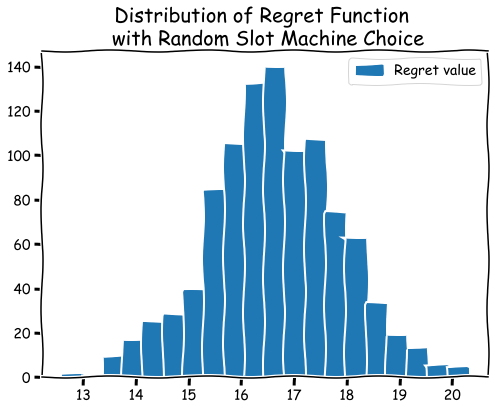

In [3]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(8,6)) 
    plt.hist([cal_simple_random_regret() for _ in range(1000)],label="Regret value",bins=20)
    ax.set_title("Distribution of Regret Function \n with Random Slot Machine Choice",fontsize=20)
    plt.legend()
    fig.savefig("random_slot_machine.jpg")

### Greedy strategy
Bob plays each machine 10 times and denote the winning probabilities. He then stick to the one with highest probabilities of winning and update his statistics accordingly. In another word, Bob is greedy.

We use the `data class` to model a record.

In [4]:
from dataclasses import dataclass

@dataclass
class Record:
    total:int
    win:int
    
    def cal_ratio(self):
        return self.win/self.total
    def update(self, prob):
        self.total += 1
        self.win += np.random.random() < prob

In [5]:
def cal_greedy_regret(N = 100, probs = [0.5, 0.3, 0.2], evaluation_step = 10):
    K = len(probs)
    Records = [Record(0,0) for _ in range(K)]
    # initial evaluation step
    for i in range(K):
        Records[i].total = evaluation_step
        Records[i].win = np.sum([np.random.random() < probs[i] for _ in range(10)])
    # get the index of the most successful slot machine so far
    slots_trajectory = []
    slot_index = np.argmax([record.cal_ratio() for record in Records])
    slots_trajectory.append(slot_index)
    for i in range(N - evaluation_step * K):
        # play the remaining 70 rounds
        Records[slot_index].update(probs[slot_index])
        slot_index = np.argmax([record.cal_ratio() for record in Records])
        slots_trajectory.append(slot_index)
#     print(Records)
    return max(probs)*N - sum([Records[i].total*probs[i] for i in range(K)]), slots_trajectory

In [6]:
reg_val, trajectory = cal_greedy_regret()

reg_val

5.600000000000001

### Choice of slot machines for greedy strategy

Note that the choice can only take values of integers as they are indices.

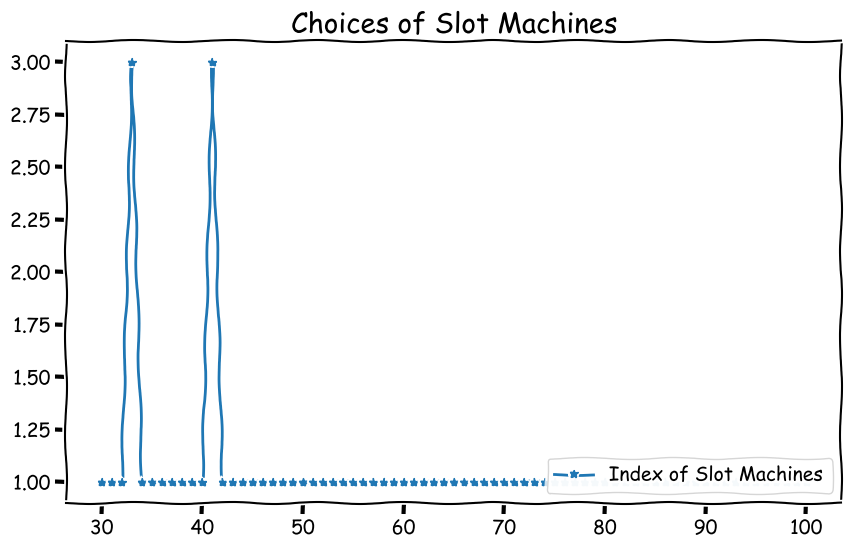

In [7]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10,6)) 
    plt.plot(range(30,101),np.array(trajectory) + 1,label="Index of Slot Machines",marker = "*")
    ax.set_title("Choices of Slot Machines",fontsize=20)
    plt.legend(loc='lower right')
#     fig.savefig("trajectory.jpg")

### Greedy-epsilon strategy

In [8]:
def cal_greedy_epsilon_regret(N = 100, probs = [0.5, 0.3, 0.2], evaluation_step = 5, epsilon = 0.1):
    K = len(probs)
    Records = [Record(0,0) for _ in range(K)]
    # initial evaluation step
    for i in range(K):
        Records[i].total = evaluation_step
        Records[i].win = np.sum([np.random.random() < probs[i] for _ in range(10)])
    
    # get the index of the most successful slot machine so far
    slots_trajectory = []
    slot_index = np.argmax([record.cal_ratio() for record in Records])
    slots_trajectory.append(slot_index)
    for i in range(N - evaluation_step * K):
        Records[slot_index].update(probs[slot_index])
        slot_index = np.argmax([record.cal_ratio() for record in Records])
        # determine whether we want to explore or exploit in next round
        if np.random.random() < epsilon:
            # explore
            slot_index = np.random.choice([i for i in range(K) if i != slot_index])
        slots_trajectory.append(slot_index)
#     print(Records)
    return max(probs)*N - sum([Records[i].total*probs[i] for i in range(K)]), slots_trajectory

In [9]:
rounds = 1000
greedy_only = [cal_greedy_regret(evaluation_step=1)[0] for _ in range(rounds)]
greedy_epsilon = [cal_greedy_epsilon_regret(epsilon=0.02)[0] for _ in range(rounds)]

### Comparing greedy only approach and greedy epsilon approach

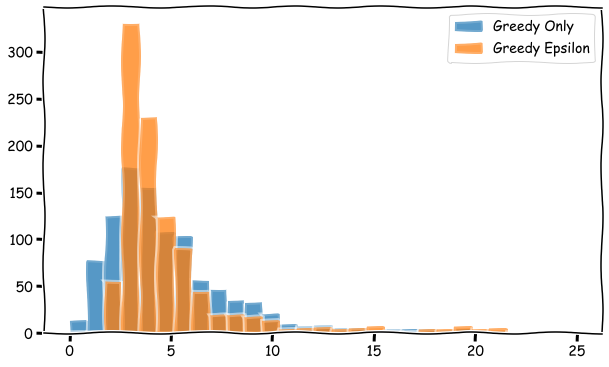

In [10]:
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(10,6)) 
    plt.hist(greedy_only,label="Greedy Only",bins=np.linspace(0,25,30),alpha=0.5)
    plt.hist(greedy_epsilon,label="Greedy Epsilon",bins=np.linspace(0,25,30),alpha=0.5)
    plt.legend(loc='upper right')
#     fig.savefig("greedy_approach_epsilon_compare.jpg")

## Bayesian statistics

In [9]:
from scipy import stats

#### Visualizing the Beta distribution

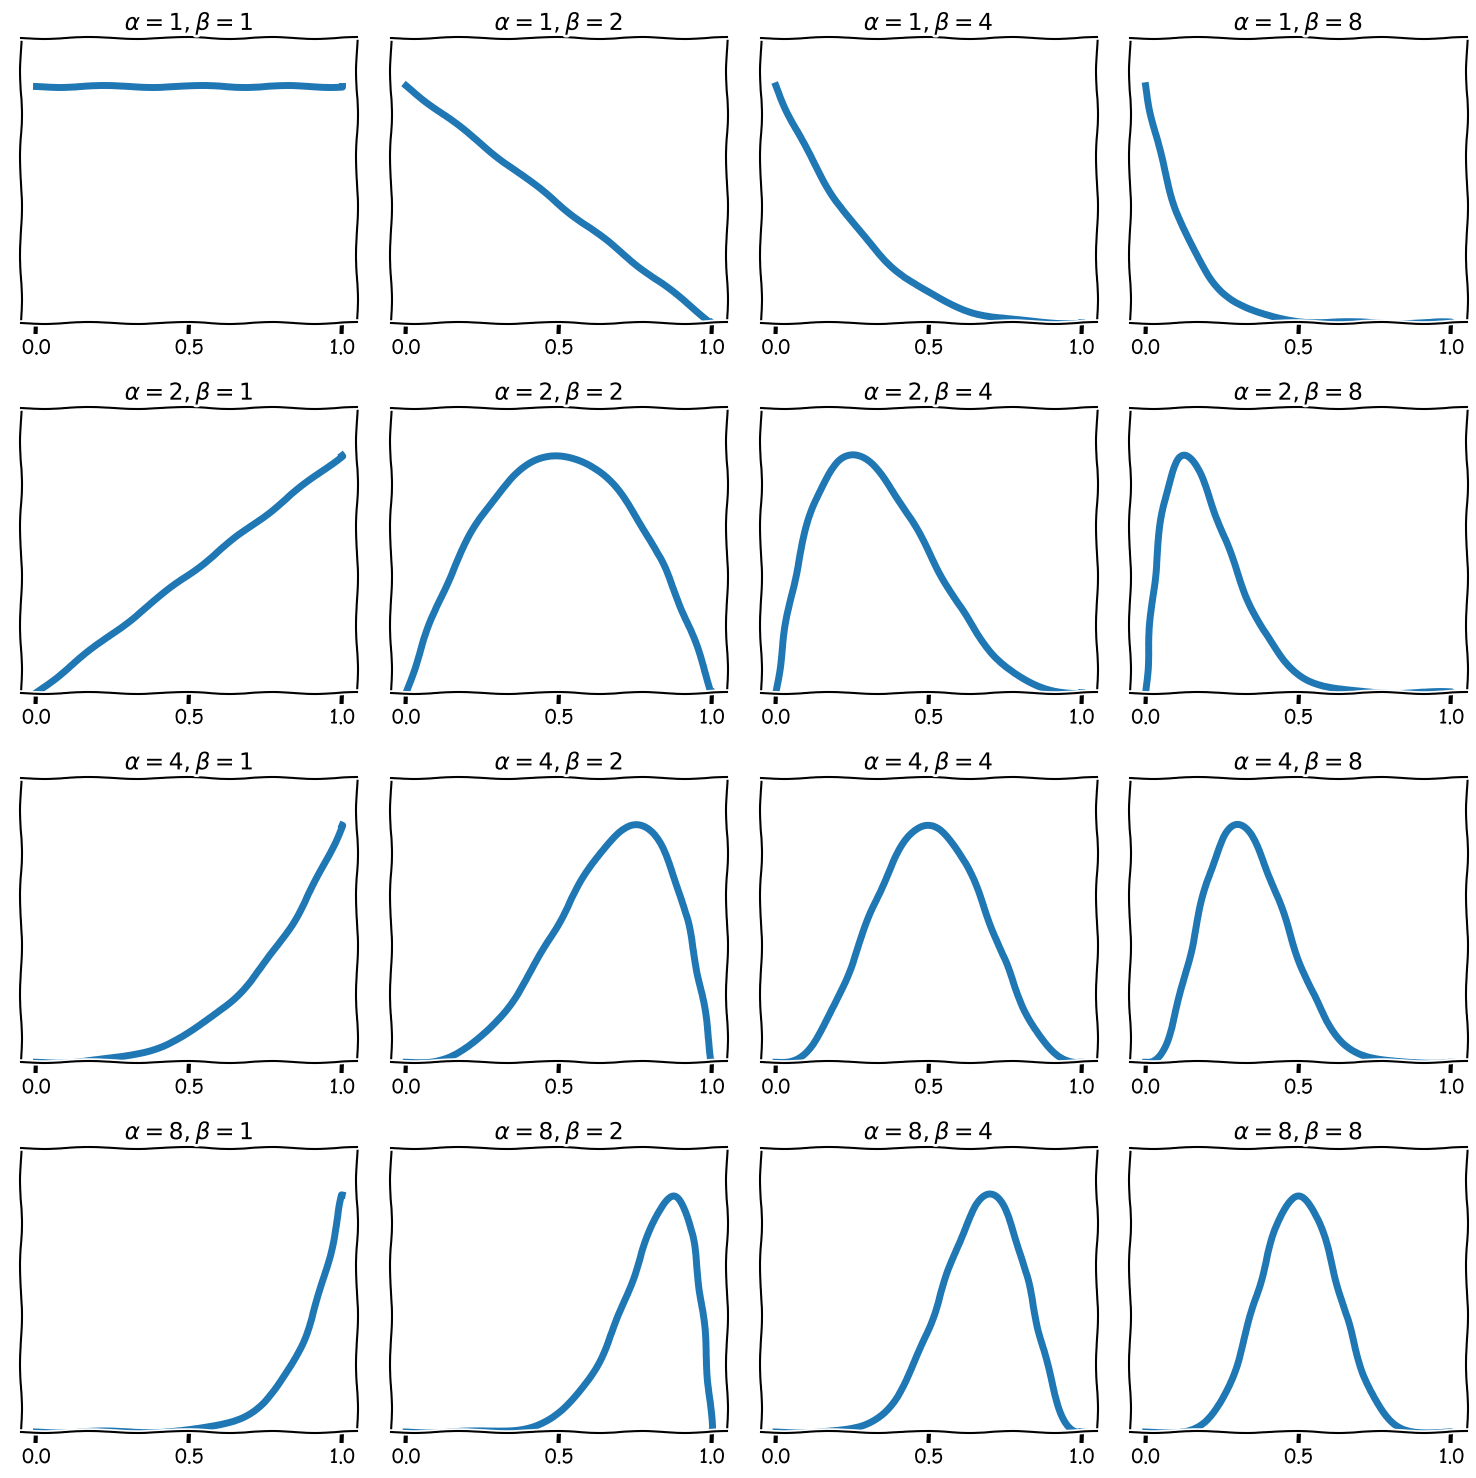

In [10]:
def plot_beta(alpha, beta, ax, title=None, label=None, xticks=[0.0, 0.5, 1.0]):

    # Build a beta distribtuion scipy object.
    dist = stats.beta(alpha, beta)

    # The support (always this for the beta dist).
    x = np.linspace(0.0, 1.0, 201)

    # The probability density at each sample support value.
    y = dist.pdf(x)

    # Plot it all.
    lines = ax.plot(x, y, label=label,linewidth=5)
    if title: 
        ax.set_title(title)
    ax.get_yaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([np.max(y)])
    ax.get_xaxis().set_ticks(xticks)
    ax.set_ylim(0.0, np.max(y)*1.2)

# The shape parameters.
alpha_values = [1, 2, 4, 8]  
beta_values  = [1, 2, 4, 8]
n_rows, n_cols = len(alpha_values), len(beta_values)
alpha_beta_pairs = ( (i, j) for i in alpha_values for j in beta_values )
with plt.xkcd():
    # Create a large figure - nice way to do it.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    # Plot each beta dist. One plot per pair of shape params.
    for (alpha, beta), ax in zip(alpha_beta_pairs, axes.flatten()):
        plot_beta(alpha, beta, ax, r"$\alpha={} ,  \beta={}$".format(alpha, beta))

    plt.tight_layout()
    fig.savefig("beta_distributions.jpg")

### Distributions evolve as more and more observations are made

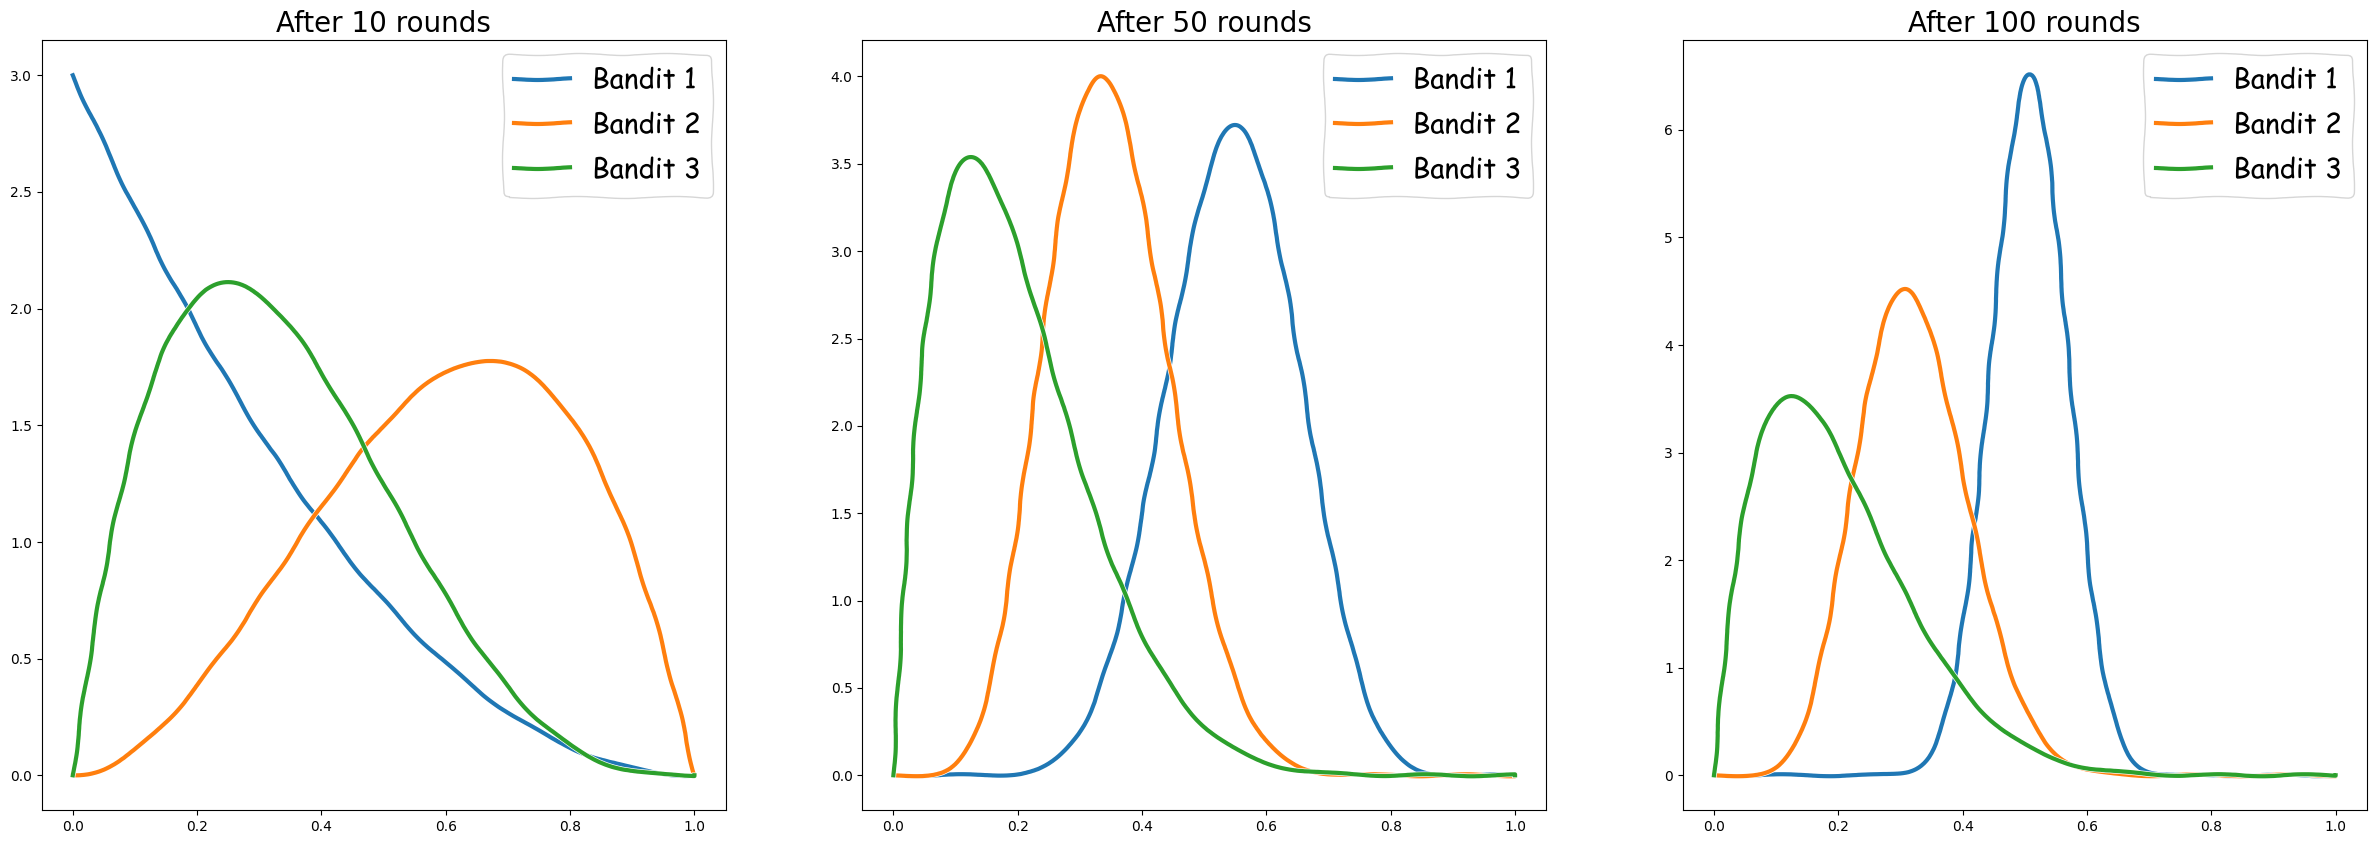

In [11]:
probs = [0.5, 0.3, 0.2]
K = len(probs)
N = 100
rounds = [9, 49, 99]
fig, axis = plt.subplots(1, 3, figsize= (30,10))
x_ticks = np.linspace(0,1,500)
plot_index = 0
betas = [stats.beta(1,1) for _ in range(K)]
wins = [0, 0, 0]
totals = [0, 0, 0]

with plt.xkcd():
    for rnd in range(N):
        for i in range(K):
            betas[i] = stats.beta(1+wins[i],1+totals[i]-wins[i])
        # determine next round's slot machine
        p_value_samples = np.array([betas[i].rvs() for i in range(K)])
        slot_next_round_index = p_value_samples.argmax()
        win = np.random.random() < probs[slot_next_round_index]
        wins[slot_next_round_index] += win
        totals[slot_next_round_index] += 1
        if rnd in rounds:
            ax = axis[plot_index]
            for i in range(K):
                # plotting
                beta = betas[i]
                ax.plot(x_ticks, beta.pdf(x_ticks), 
                        label='Bandit {}'.format(i+1),
                        linewidth=3)
                ax.set_title('After {} rounds'.format(rnd + 1),fontsize=20)
                ax.legend(fontsize=20)
            plot_index+=1
fig.savefig("bayesian_simulation.jpg")

### Another set of ground truth

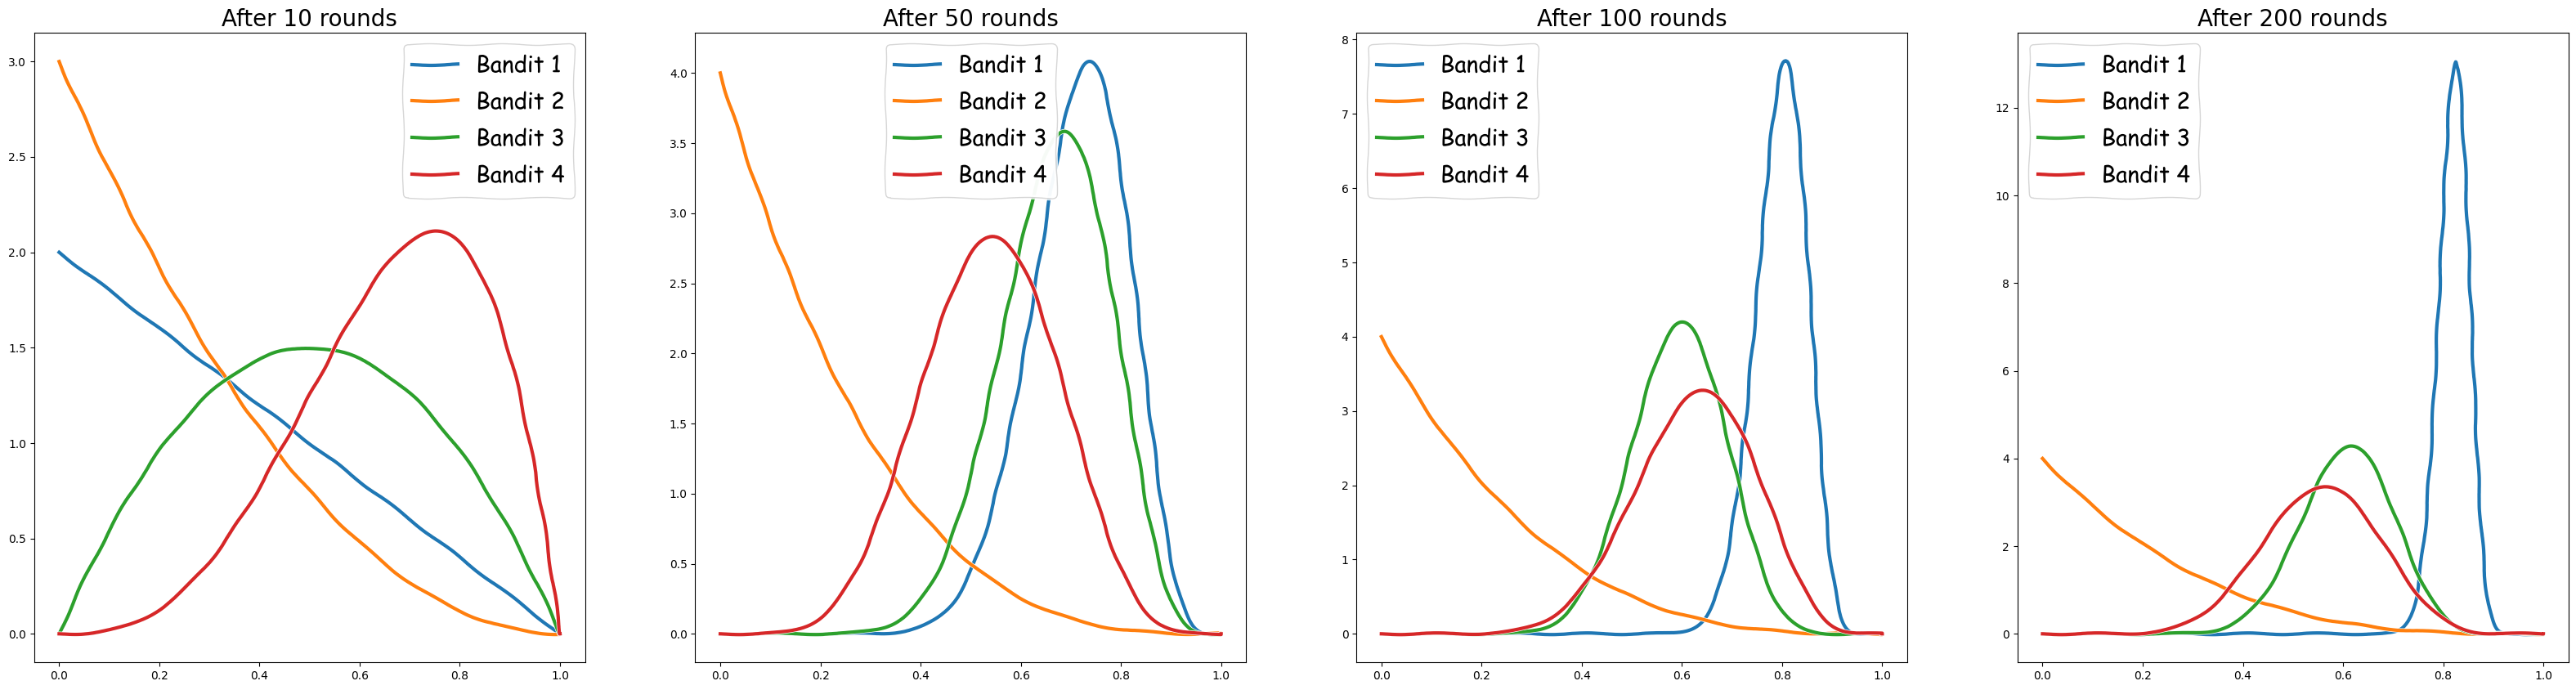

In [12]:
probs = [0.8,0.7,0.6,0.5]
K = len(probs)
N = 200
rounds = [9, 49, 99,199]
fig, axis = plt.subplots(1, 4, figsize= (40,10))
x_ticks = np.linspace(0,1,500)
plot_index = 0
betas = [stats.beta(1,1) for _ in range(K)]
wins = [0 for _ in range(K)]
totals = [0 for _ in range(K)]

with plt.xkcd():
    for rnd in range(N):
        for i in range(K):
            betas[i] = stats.beta(1+wins[i],1+totals[i]-wins[i])
        # determine next round's slot machine
        p_value_samples = np.array([betas[i].rvs() for i in range(K)])
        slot_next_round_index = p_value_samples.argmax()
        win = np.random.random() < probs[slot_next_round_index]
        wins[slot_next_round_index] += win
        totals[slot_next_round_index] += 1
        if rnd in rounds:
            ax = axis[plot_index]
            for i in range(K):
                # plotting
                beta = betas[i]
                ax.plot(x_ticks, beta.pdf(x_ticks), 
                        label='Bandit {}'.format(i+1),
                        linewidth=3)
                ax.set_title('After {} rounds'.format(rnd + 1),fontsize=20)
                ax.legend(fontsize=20)
            plot_index+=1
# plt.tight_layout()
fig.savefig("bayesian_simulation_4.jpg")